In [1]:
# !pip install Ninja
# !rm -rf /.cache/torch_extensions

In [2]:
#title Imports
from typing import Optional, Tuple, List
import six.moves.cPickle as cPickle
import tensorflow as tf
import numpy as np
import requests
import tqdm
import collections
import os
import zipfile
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from io import BytesIO
import IPython.display
import torch
from torchvision import models
from torch.utils.data import Dataset, DataLoader

In [3]:
device = 'cuda'

In [5]:
from model import Generator, Discriminator, Encoder
from classifier_train import create_dataset
classifier = models.mobilenet_v2(pretrained=False, num_classes=2).to(device)
classifier.load_state_dict(torch.load("classifier_model.pt"))

<All keys matched successfully>

In [6]:
x = torch.load('240000.pt')
y = torch.load('240000.pt')

In [7]:

for key in y['g_ema'].keys():
  if key[:5] ==  'style':
    x['g_ema']['mapping'+key[5:]]= x['g_ema'][key]
    del x['g_ema'][key]
  if key[-17:]=='modulation.weight':
    if 'rgb' in key:
      if key[6] == '1':
        x['g_ema']['style_affines_rgb.0.modulation.weight']= x['g_ema'][key]
        del x['g_ema'][key]
      else:
        x['g_ema']['style_affines_rgb.'+str(int(key[8:10].strip('.'))+1)+'.modulation.weight']= x['g_ema'][key]
        del x['g_ema'][key]
    else:
      if key[4] == '1':
        x['g_ema']['style_affines_conv.0.modulation.weight']= x['g_ema'][key]
        del x['g_ema'][key]
      else:
        x['g_ema']['style_affines_conv.'+str(int(key[6:8].strip('.'))+1)+'.modulation.weight']= x['g_ema'][key]
        del x['g_ema'][key]
  if key[-15:]=='modulation.bias':
    if 'rgb' in key:
      if key[6] == '1':
        x['g_ema']['style_affines_rgb.0.modulation.bias']= x['g_ema'][key]
        del x['g_ema'][key]
      else:
        x['g_ema']['style_affines_rgb.'+str(int(key[8:10].strip('.'))+1)+'.modulation.bias']= x['g_ema'][key]
        del x['g_ema'][key]
    else:
      if key[4] == '1':
        x['g_ema']['style_affines_conv.0.modulation.bias']= x['g_ema'][key]
        del x['g_ema'][key]
      else:
        x['g_ema']['style_affines_conv.'+str(int(key[6:8].strip('.'))+1)+'.modulation.bias']= x['g_ema'][key]
        del x['g_ema'][key]
del y

In [8]:
resolution = 64

discriminator = Discriminator(
        resolution
    ).to(device)
discriminator.load_state_dict(x['d'])
generator = Generator(
    resolution, 512, 8
).to(device)
generator.load_state_dict(x['g_ema'], strict=False)
# encoder = Encoder(resolution).to(device)
# encoder.load_state_dict(x['e'])

num_layers=len(generator.style_affines_conv)
label_size=2

In [9]:
#@title Utils {form-width: '20%'}

def make_animation(image: torch.Tensor,
                   resolution: int,
                   figsize: Tuple[int, int] = (20, 8)):
  fig = plt.figure(1, figsize=figsize)
  _ = plt.gca()
  image = image.cpu().detach().numpy().astype(np.uint8)
  def transpose_image(image):
    image_reshape = image.reshape([-1, resolution, resolution, 3])
    return image_reshape.transpose([1, 0, 2, 3]).reshape([resolution, -1, 3])
  im = plt.imshow(transpose_image(image[:, :resolution, :]),
                  interpolation='none')
  def animate_func(i):
    im.set_array(transpose_image(image[:, resolution*i:resolution*(i+1), :]))
    return [im]

  animation = matplotlib.animation.FuncAnimation(
      fig, animate_func, frames=image.shape[1] // resolution, interval=600)

  plt.close(1)
  return animation


def show_image(image, fmt='png'):
  image = image.cpu().detach()
  if image.dtype == torch.int:
    image = np.uint8(image)
  elif image.dtype == torch.float:
    image = np.uint8(image * 127.5 + 127.5)
  if image.shape[0] == 3:
    image = np.transpose(image, (1, 2, 0))
  bytes_io = BytesIO()
  Image.fromarray(image).save(bytes_io, fmt)
  IPython.display.display(IPython.display.Image(data=bytes_io.getvalue()))


def filter_unstable_images(style_change_effect: np.ndarray,
                           effect_threshold: float = 0.3,
                           num_indices_threshold: int = 750) -> np.ndarray:
  """Filters out images which are affected by too many S values."""
  unstable_images = (
      np.sum(np.abs(style_change_effect) > effect_threshold, axis=(1, 2, 3)) >
      num_indices_threshold)
  style_change_effect[unstable_images] = 0
  return style_change_effect

def call_synthesis(generator: Generator,
                   dlatents_in: torch.Tensor,
                   conditioning_in: Optional[torch.Tensor] = None,
                   labels_in: Optional[torch.Tensor] = None,
                   training: bool = False,
                   num_layers: int = 14,
                   dlatent_size: int = 512,
                   input_is_styles: bool = False,
                   styles: Optional[torch.Tensor] = None) -> torch.Tensor:
  """Calls the synthesis.

  Args:
    dlatents_in: the intermediate latent representation of shape [batch size,
      num_layers, dlatent_size].
    conditioning_in: Conditioning input to the synthesis network (can be an
      image or output from an encoder) of shape [minibatch, channels,
      resolution, resolution]. Set to None if unused.
    labels_in: of shape [batch_size, label_size]. Set to None if unused.
    training: Whether this is a training call.

  Returns:
    The output images and optional latent vector.

  """
  if labels_in is not None:
    zero_labels = torch.zeros_like(labels_in)
    dlatents_labels = torch.tile(torch.unsqueeze(labels, 1), [1, num_layers, 1])
    if dlatent_size > 0:
      dlatents_expanded = torch.concat([dlatents_in, dlatents_labels], axis=2)
    else:
      dlatents_expanded = dlatents_labels
  else:
    if dlatent_size == 0:
      raise ValueError('Dlatents are empty and no labels were provided.')
    dlatents_expanded = dlatents_in
  # Evaluate synthesis network.
  generator.train(training)
  style_vector_blocks, style_vector_torgb = generator.get_styles(dlatents_expanded)
  if conditioning_in is not None:
    network_inputs = (style_vector_blocks, style_vector_torgb,
                      conditioning_in)
  else:
    network_inputs = (style_vector_blocks, style_vector_torgb)

  if input_is_styles:
    network_inputs = styles
  
  synthesis_results = generator(styles=network_inputs, input_is_styles=True)[0]

  # Return requested outputs.
  return torch.clamp(synthesis_results, -1, 1)


def discriminator_filter(style_change_effect: np.ndarray,
                         all_dlatents: np.ndarray,
                         generator: Generator,
                         discriminator: Discriminator,
                         classifier: torch.nn.Module,
                         sindex: int,
                         style_min: float,
                         style_max: float,
                         class_index: int,
                         num_images: int = 10,
                         label_size: int = 2,
                         change_threshold: float = 0.5,
                         shift_size: float = 2,
                         effect_threshold: float = 0.2,
                         sindex_offset: int = 0) -> bool:
  """Returns false if changing the style index adds artifacts to the images.

  Args:
    style_change_effect: A shape of [num_images, 2, style_size, num_classes].
      The effect of each change of style on specific direction on each image.
    all_dlatents: The dlatents of each image, shape of [num_images,
      dlatent_size].
    generator: The generator model. Either StyleGAN or GLO.
    discriminator: The discriminator model.
    sindex: The style index.
    style_min: The style min value in all images.
    style_max: The style max value in all images.
    class_index: The index of the class to check.
    num_images: The number of images to do the disciminator_filter test.
    label_size: The label size.
    change_threshold: The maximal change allowed in the discriminator
      prediction.
    shift_size: The size to shift the style index.
    effect_threshold: Used for choosing images that the classification was
      changed enough.
    sindex_offset: The offset of the style index if style_change_effect contains
      some of the layers and not all styles.
  """
  for style_sign_index in range(2):
    images_idx = ((style_change_effect[:, style_sign_index, sindex,
                                       class_index]) >
                  effect_threshold).nonzero()[0]

    images_idx = images_idx[:num_images]
    dlatents = all_dlatents[images_idx]

    for i in range(len(images_idx)):
      cur_dlatent = dlatents[i:i + 1]
      (discriminator_orig, 
       discriminator_change) = get_discriminator_results_given_dlatent(
           dlatent=cur_dlatent,
           generator=generator,
           discriminator=discriminator,
           classifier=classifier,
           class_index=class_index,
           sindex=sindex + sindex_offset,
           s_style_min=style_min,
           s_style_max=style_max,
           style_direction_index=style_sign_index,
           shift_size=shift_size,
           label_size=label_size)

      if np.abs((discriminator_orig - discriminator_change).cpu().detach()) > change_threshold:
        return False
  return True


def find_significant_styles_image_fraction(
    style_change_effect: np.ndarray,
    num_indices: int,
    class_index: int,
    generator: Generator,
    classifier: torch.nn.Module,
    all_dlatents: np.ndarray,
    style_min: np.ndarray,
    style_max: np.ndarray,
    effect_threshold: float = 0.2,
    min_changed_images_fraction: float = 0.03,
    label_size: int = 2,
    sindex_offset: int = 0,
    discriminator: Optional[Discriminator] = None,
    discriminator_threshold: float = 0.2) -> List[Tuple[int, int]]:
  """Returns indices in the style vector which affect the classifier.

  Args:
    style_change_effect: A shape of [num_images, 2, style_size, num_classes].
      The effect of each change of style on specific direction on each image.
    num_indices: Number of styles in the result.
    class_index: The index of the class to visualize.
    generator: The generator model. Either StyleGAN or GLO.
    all_dlatents: The dlatents of each image, shape of [num_images,
      dlatent_size].
    style_min: An array with the min value for each style index.
    style_max: An array with the max value for each style index.
    effect_threshold: Minimal change of classifier output to be considered.
    min_changed_images_fraction: Minimal fraction of images which are changed.
    label_size: The label size.
    sindex_offset: The offset of the style index if style_change_effect contains
      some of the layers and not all styles.
    discriminator: The discriminator model. If None, don't filter style indices.
    discriminator_threshold: Used in discriminator_filter to define the maximal
      change allowed in the discriminator prediction.
    
  """
  effect_positive = np.sum(
      style_change_effect[:, :, :, class_index] > effect_threshold, axis=0)
  effect_positive = effect_positive.flatten()
  all_sindices = []
  sindices = np.argsort(effect_positive)[::-1]
  if discriminator is not None:
    print('Using discriminator...')
  for sindex in sindices[:num_indices*2]:
    if (effect_positive[sindex] <
        min_changed_images_fraction * style_change_effect.shape[0]):
      break
    if discriminator is not None:
      s_index = sindex % style_change_effect.shape[2]
      if not discriminator_filter(
          style_change_effect,
          all_dlatents,
          generator,
          discriminator,
          classifier,
          s_index,
          style_min[s_index + sindex_offset],
          style_max[s_index + sindex_offset],
          class_index,
          label_size=label_size,
          change_threshold=discriminator_threshold,
          sindex_offset=sindex_offset):
        continue
    all_sindices.append(sindex)
    if len(all_sindices) == num_indices:
      break

  return [(x // style_change_effect.shape[2],
           (x % style_change_effect.shape[2]) + sindex_offset)
          for x in all_sindices]


def find_significant_styles(
    style_change_effect: np.ndarray,
    num_indices: int,
    class_index: int,
    discriminator: Optional[Discriminator],
    generator: Generator,
    classifier: torch.nn.Module,
    all_dlatents: np.ndarray,
    style_min: np.ndarray,
    style_max: np.ndarray,
    max_image_effect: float = 0.2,
    label_size: int = 2,
    discriminator_threshold: float = 0.2,
    sindex_offset: int = 0) -> List[Tuple[int, int]]:
  """Returns indices in the style vector which affect the classifier.

  Args:
    style_change_effect: A shape of [num_images, 2, style_size, num_classes].
      The effect of each change of style on specific direction on each image.
    num_indices: Number of styles in the result.
    class_index: The index of the class to visualize.
    discriminator: The discriminator model. If None, don't filter style indices.
    generator: The generator model. Either StyleGAN or GLO.
    all_dlatents: The dlatents of each image, shape of [num_images,
      dlatent_size].
    style_min: An array with the min value for each style index.
    style_max: An array with the max value for each style index.
    max_image_effect: Ignore contributions of styles if the previously found
      styles changed the probability of the image by more than this threshold.
    label_size: The label size.
    discriminator_threshold: Used in discriminator_filter to define the maximal
      change allowed in the discriminator prediction.
    sindex_offset: The offset of the style index if style_change_effect contains
      some of the layers and not all styles.
  """

  num_images = style_change_effect.shape[0]
  style_effect_direction = np.maximum(
      0, style_change_effect[:, :, :, class_index].reshape((num_images, -1)))

  images_effect = np.zeros(num_images)
  all_sindices = []
  discriminator_removed = []
  while len(all_sindices) < num_indices:
    next_s = np.argmax(
        np.mean(
            style_effect_direction[images_effect < max_image_effect], axis=0))
    if discriminator is not None:
      sindex = next_s % style_change_effect.shape[2]
      if sindex == 0:
        break
      if not discriminator_filter(
          style_change_effect=style_change_effect,
          all_dlatents=all_dlatents,
          generator=generator,
          discriminator=discriminator,
          classifier=classifier,
          sindex=sindex,
          style_min=style_min[sindex + sindex_offset],
          style_max=style_max[sindex + sindex_offset],
          class_index=class_index,
          label_size=label_size,
          change_threshold=discriminator_threshold,
          sindex_offset=sindex_offset):
        style_effect_direction[:, next_s] = np.zeros(num_images)
        discriminator_removed.append(sindex)
        continue

    all_sindices.append(next_s)
    images_effect += style_effect_direction[:, next_s]
    style_effect_direction[:, next_s] = 0
  return [(x // style_change_effect.shape[2],
           (x % style_change_effect.shape[2]) + sindex_offset)
          for x in all_sindices]


def _float_features(values):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=values))

LAYER_SHAPES = []
for dense in generator.style_affines_conv._modules.values():
  LAYER_SHAPES.append(dense.modulation.bias.size(0))


def sindex_to_layer_idx_and_index(generator: Generator,
                                  sindex: int) -> Tuple[int, int]:
  global LAYER_SHAPES
  layer_shapes_cumsum = np.concatenate([[0], np.cumsum(LAYER_SHAPES)])
  layer_idx = (layer_shapes_cumsum <= sindex).nonzero()[0][-1]
  return layer_idx, sindex - layer_shapes_cumsum[layer_idx]


def get_classifier_results(generator: Generator, 
                           expanded_dlatent: torch.Tensor,
                           use_softmax: bool = False,
                           batch_size=1,
                           input_is_styles: bool = False,
                           styles: Optional[torch.Tensor] = None):
  img = call_synthesis(generator, expanded_dlatent, 
                       input_is_styles=input_is_styles, styles=styles)
  classifier.eval()
  results = classifier(img).cpu().detach()
  if use_softmax:
    results =  torch.nn.functional.softmax(results).numpy()
  else:
    results = results.numpy()

  if batch_size == 1:
    return results[0]
  return results


def draw_on_image(image: np.ndarray, number: float,
                  font_file: str,
                  font_fill: Tuple[int, int, int] = (0, 0, 255)) -> np.ndarray:
  """Draws a number on the top left corner of the image."""
  fnt = ImageFont.truetype(font_file, 20)
  image = image.cpu().detach().numpy()
  out_image = Image.fromarray((image * 127.5 + 127.5).astype(np.uint8))
  draw = ImageDraw.Draw(out_image)
  draw.multiline_text((10, 10), ('%.3f' % number), font=fnt, fill=font_fill)
  return torch.tensor(np.array(out_image)).to(device)


def generate_change_image_given_dlatent(
    dlatent: np.ndarray,
    generator: Generator,
    classifier: Optional[torch.nn.Module],
    class_index: int,
    sindex: int,
    s_style_min: float,
    s_style_max: float,
    style_direction_index: int,
    shift_size: float,
    label_size: int = 2,
) -> Tuple[np.ndarray, float, float]:
  """Modifies an image given the dlatent on a specific S-index.

  Args:
    dlatent: The image dlatent, with sape [dlatent_size].
    generator: The generator model. Either StyleGAN or GLO.
    classifier: The classifier to visualize.
    class_index: The index of the class to visualize.
    sindex: The specific style index to visualize.
    s_style_min: The minimal value of the style index.
    s_style_max: The maximal value of the style index.
    style_direction_index: If 0 move s to it's min value otherwise to it's max
      value.
    shift_size: Factor of the shift of the style vector.
    label_size: The size of the label.

  Returns:
    The image after the style index modification, and the output of
    the classifier on this image.
  """
  expanded_dlatent = torch.tile(
          torch.unsqueeze(dlatent, 1),
          [1, num_layers, 1])
  network_inputs = generator.get_styles(expanded_dlatent)
  generator.eval()
  style_vector = torch.concat(
        generator.get_styles(expanded_dlatent)[0],
        dim=1).cpu().detach().numpy()
  orig_value = style_vector[0, sindex]
  target_value = (s_style_min if style_direction_index == 0 else s_style_max)

  weight_shift = shift_size * (target_value - orig_value)

  layer_idx, in_idx = sindex_to_layer_idx_and_index(generator,  sindex)
  layer_one_hot = torch.unsqueeze(
      torch.nn.functional.one_hot(torch.tensor(in_idx).to(device).to(torch.int64), network_inputs[0][layer_idx].shape[1]), 0)
  network_inputs[0][layer_idx] += (weight_shift * layer_one_hot)
  images_out, _, _ =  generator(styles=network_inputs, input_is_styles=True)
  images_out = torch.clamp(images_out, -1, 1)
  classifier.eval()
  result = classifier(images_out)
  change_prob = torch.nn.functional.softmax(result).cpu().detach().numpy()[0, class_index]
  return images_out, change_prob



def get_discriminator_results_given_dlatent(
    dlatent: np.ndarray,
    generator: Generator,
    discriminator: Discriminator,
    classifier: torch.nn.Module,
    class_index: int,
    sindex: int,
    s_style_min: float,
    s_style_max: float,
    style_direction_index: int,
    shift_size: float = 2,
    label_size: int = 2,
) -> Tuple[float, float]:
  """Modifies an image given the dlatent on a specific S-index.

  Args:
    dlatent: The image dlatent, with sape [dlatent_size].
    generator: The generator model. Either StyleGAN or GLO.
    class_index: The index of the class to visualize.
    sindex: The specific style index to visualize.
    s_style_min: The minimal value of the style index.
    s_style_max: The maximal value of the style index.
    style_direction_index: If 0 move s to it's min value otherwise to it's max
      value.
    shift_size: Factor of the shift of the style vector.
    label_size: The size of the label.

  Returns:
    The discriminator before and after.
  """
  dlatent = torch.tensor(dlatent).to(device).to(torch.float)
  expanded_dlatent = torch.tile(
          torch.unsqueeze(dlatent, 1),
          [1, num_layers, 1])
  network_inputs = generator.get_styles(expanded_dlatent)
  images_out, _, _ =  generator(styles=network_inputs, input_is_styles=True)
  images_out = torch.clamp(images_out, -1, 1)
  labels = torch.tensor(dlatent[:, -label_size:], dtype=torch.float32).to(device)
  discriminator.eval()
  discriminator_before = discriminator(images_out)
  # I am not using the classifier output here, because it is only one.
  change_image, _ = (
      generate_change_image_given_dlatent(dlatent, generator, classifier,
                                          class_index, sindex,
                                          s_style_min, s_style_max,
                                          style_direction_index, shift_size,
                                          label_size))
  labels = torch.nn.functional.softmax(classifier(change_image))

  discriminator_after = discriminator(change_image)
  return (discriminator_before, discriminator_after)


def generate_images_given_dlatent(
    dlatent: np.ndarray,
    generator: Generator,
    classifier: Optional[torch.nn.Module],
    class_index: int,
    sindex: int,
    s_style_min: float,
    s_style_max: float,
    style_direction_index: int,
    font_file: Optional[str],
    shift_size: float = 2,
    label_size: int = 2,
    draw_results_on_image: bool = True,
    resolution: int = 64,
) -> Tuple[np.ndarray, float, float, float, float]:
  """Modifies an image given the dlatent on a specific S-index.

  Args:
    dlatent: The image dlatent, with sape [dlatent_size].
    generator: The generator model. Either StyleGAN or GLO.
    classifier: The classifier to visualize.
    class_index: The index of the class to visualize.
    sindex: The specific style index to visualize.
    s_style_min: The minimal value of the style index.
    s_style_max: The maximal value of the style index.
    style_direction_index: If 0 move s to it's min value otherwise to it's max
      value.
    font_file: A path to the font file for writing the probability on the image.
    shift_size: Factor of the shift of the style vector.
    label_size: The size of the label.
    draw_results_on_image: Whether to draw the classifier outputs on the images.

  Returns:
    The image before and after the style index modification, and the outputs of
    the classifier before and after the
    modification.
  """
  dlatent = torch.tensor(dlatent).to(device).to(torch.float)
  expanded_dlatent = torch.tile(
          torch.unsqueeze(dlatent, 1),
          [1, num_layers, 1])
  network_inputs = generator.get_styles(expanded_dlatent)
  result_image = torch.zeros((resolution, 2 * resolution, 3))
  generator.eval()
  base_image, _, _ = generator(styles=network_inputs, input_is_styles=True)
  base_image = torch.clamp(base_image, -1, 1,)
  classifier.eval()
  result = classifier(base_image)
  base_image = torch.movedim(base_image, 1, 3)
  base_prob = torch.nn.functional.softmax(result)[0, class_index]
  if draw_results_on_image:
    result_image[:, :resolution, :] = draw_on_image(
        base_image[0], base_prob, font_file)
  else:
    result_image[:, :resolution, :] = (base_image[0] * 127.5 +
                                       127.5)

  change_image, change_prob = (
      generate_change_image_given_dlatent(dlatent, generator, classifier,
                                          class_index, sindex,
                                          s_style_min, s_style_max,
                                          style_direction_index, shift_size,
                                          label_size))
  change_image = torch.movedim(change_image, 1, 3)
  if draw_results_on_image:
    result_image[:, resolution:, :] = draw_on_image(
        change_image[0], change_prob, font_file)
  else:
    result_image[:, resolution:, :] = (
        torch.clamp(change_image[0], -1, 1) * 127.5 +
                                               127.5)

  return (result_image.to(torch.int), change_prob, base_prob)



def visualize_style(generator: Generator,
                    classifier: torch.nn.Module,
                    all_dlatents: np.ndarray,
                    style_change_effect: np.ndarray,
                    style_min: np.ndarray,
                    style_max: np.ndarray,
                    sindex: int,
                    style_direction_index: int,
                    max_images: int,
                    shift_size: float,
                    font_file: str,
                    label_size: int = 2,
                    class_index: int = 0,
                    effect_threshold: float = 0.3,
                    seed: Optional[int] = None,
                    allow_both_directions_change: bool = False,
                    draw_results_on_image: bool = True) -> np.ndarray:
  """Returns an image visualizing the effect of a specific S-index.

  Args:
    generator: The generator model. Either StyleGAN or GLO.
    classifier: The classifier to visualize.
    all_dlatents: An array with shape [num_images, dlatent_size].
    style_change_effect: A shape of [num_images, 2, style_size, num_classes].
      The effect of each change of style on specific direction on each image.
    style_min: The minimal value of each style, with shape [style_size].
    style_max: The maximal value of each style, with shape [style_size].
    sindex: The specific style index to visualize.
    style_direction_index: If 0 move s to its min value otherwise to its max
      value.
    max_images: Maximal number of images to visualize.
    shift_size: Factor of the shift of the style vector.
    font_file: A path to the font file for writing the probability on the image.
    label_size: The size of the label.
    class_index: The index of the class to visualize.
    effect_threshold: Choose images whose effect was at least this number.
    seed: If given, use this as a seed to the random shuffling of the images.
    allow_both_directions_change: Whether to allow both increasing and
      decreasing the classifiaction (used for age).
    draw_results_on_image: Whether to draw the classifier outputs on the images.
  """

  # Choose the dlatent indices to visualize
  if allow_both_directions_change:
    images_idx = (np.abs(style_change_effect[:, style_direction_index, sindex,
                                             class_index]) >
                  effect_threshold).nonzero()[0]
  else:
    images_idx = ((style_change_effect[:, style_direction_index, sindex,
                                       class_index]) >
                  effect_threshold).nonzero()[0]
  if images_idx.size == 0:
    return np.array([])

  if seed is not None:
    np.random.seed(seed)
  np.random.shuffle(images_idx)
  images_idx = images_idx[:min(max_images*10, len(images_idx))]
  dlatents = all_dlatents[images_idx]

  result_images = []
  for i in range(len(images_idx)):
    cur_dlatent = dlatents[i:i + 1]
    (result_image, base_prob, change_prob) = generate_images_given_dlatent(
         dlatent=cur_dlatent,
         generator=generator,
         classifier=classifier,
         class_index=class_index,
         sindex=sindex,
         s_style_min=style_min[sindex],
         s_style_max=style_max[sindex],
         style_direction_index=style_direction_index,
         font_file=font_file,
         shift_size=shift_size,
         label_size=label_size,
         draw_results_on_image=draw_results_on_image)

    if np.abs((change_prob - base_prob).cpu().detach()) < effect_threshold:
      continue
    result_images.append(result_image)
    if len(result_images) == max_images:
      break
  if len(result_images) < 1:
    # No point in returning results with very little images
    return torch.tensor([]).to(device)
  return torch.concat(result_images[:max_images], axis=0)


def visualize_style_by_distance_in_s(
    generator: Generator,
    classifier: torch.nn.Module,
    all_dlatents: np.ndarray,
    all_style_vectors_distances: np.ndarray,
    style_min: np.ndarray,
    style_max: np.ndarray,
    sindex: int,
    style_sign_index: int,
    max_images: int,
    shift_size: float,
    font_file: str,
    label_size: int = 2,
    class_index: int = 0,
    draw_results_on_image: bool = True,
    effect_threshold: float = 0.1) -> np.ndarray:
  """Returns an image visualizing the effect of a specific S-index.

  Args:
    generator: The generator model. Either StyleGAN or GLO.
    classifier: The classifier to visualize.
    all_dlatents: An array with shape [num_images, dlatent_size].
    all_style_vectors_distances: A shape of [num_images, style_size, 2].
      The distance each style from the min and max values on each image.
    style_min: The minimal value of each style, with shape [style_size].
    style_max: The maximal value of each style, with shape [style_size].
    sindex: The specific style index to visualize.
    style_sign_index: If 0 move s to its min value otherwise to its max
      value.
    max_images: Maximal number of images to visualize.
    shift_size: Factor of the shift of the style vector.
    font_file: A path to the font file for writing the probability on the image.
    label_size: The size of the label.
    class_index: The index of the class to visualize.
    draw_results_on_image: Whether to draw the classifier outputs on the images.
  """

  # Choose the dlatent indices to visualize
  images_idx = np.argsort(
      all_style_vectors_distances[:, sindex, style_sign_index])[::-1]
  if images_idx.size == 0:
    return np.array([])

  images_idx = images_idx[:min(max_images*10, len(images_idx))]
  dlatents = all_dlatents[images_idx]

  result_images = []
  for i in range(len(images_idx)):
    cur_dlatent = dlatents[i:i + 1]
    (result_image, change_prob, base_prob) = generate_images_given_dlatent(
         dlatent=cur_dlatent,
         generator=generator,
         classifier=classifier,
         class_index=class_index,
         sindex=sindex,
         s_style_min=style_min[sindex],
         s_style_max=style_max[sindex],
         style_direction_index=style_sign_index,
         font_file=font_file,
         shift_size=shift_size,
         label_size=label_size,
         draw_results_on_image=draw_results_on_image)
    if (change_prob - base_prob) < effect_threshold:
      continue
    result_images.append(result_image)


  if len(result_images) < 3:
    # No point in returning results with very little images
    return torch.tensor([]).to(device)
  return torch.concat(result_images[:max_images], dim=0)


# Latents extraction: 
We don't provide the dataset_provider, so we will load the dlatents from a precomputed np.array.
Here we present how to run the encoder on one image, to calculate one dlatent (we pre-calculate for 250)

`TODO:` remove this code (or replace the image with a better reconstruction)

In [9]:
#regular stylegan2
latents = []

max_batch = 1000//4
for i in tqdm.tqdm(range(max_batch)):
  latent = generator.get_latent(torch.randn(4, 512, device=device))
  latents.append(latent.cpu().detach())
  del latent
dlatents = torch.concat(latents)

100%|███████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 181.18it/s]


In [10]:
# classifier = torch.load('pretrained_class.pt')

In [11]:
# train_data = create_dataset('afhq/train/', 64, ['cat', 'dog'])
# loader = DataLoader(train_data, batch_size=4, shuffle=True)

In [12]:
#stylex stylegan2
# latents = []
# encoder.eval()
# max_batch = 1000/4
# for i, batch in tqdm.tqdm(enumerate(loader)):
#   if i >= max_batch:
#     break
#   batch = torch.movedim(batch, 3, 1).to(device)
#   encoded = encoder(batch)
#   batch_classes = classifier(batch)
#   latent = torch.concat((encoded, batch_classes),dim=1)
#   latents.append(latent.cpu().detach())
#   del batch
#   del encoded
#   del batch_classes
#   del latent
# dlatents = torch.concat(latents)

In [13]:
torch.cuda.empty_cache()

C:\Users\Rutger\Documents\GitHub\FACTinAI\op\conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.0+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


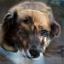

In [14]:
#@title Generate image from the dlatent
dlatent_index =  3#@param {type: "integer"}

expanded_dlatent_tmp = torch.tile(
      torch.unsqueeze(dlatents[dlatent_index], 0),
      [1, num_layers, 1]).to(device)

rec_image = call_synthesis(generator,
    expanded_dlatent_tmp,
    num_layers=num_layers)
image = rec_image[0]
show_image(image)

In [15]:
expanded_dlatent_tmp = torch.tile(
      torch.unsqueeze(torch.tensor(dlatents[:10]), 1),
      [1, num_layers, 1]).to(device)


styles = generator.get_styles(expanded_dlatent_tmp.to(device))
imgs,_, _ = generator(styles=styles, input_is_styles=True)
classes = classifier(imgs)
classes

<ipython-input-15-448b101420e8>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.unsqueeze(torch.tensor(dlatents[:10]), 1),


tensor([[ 4.5693, -4.5687],
        [-1.5300,  1.5903],
        [-1.1190,  1.1605],
        [-4.3042,  4.4331],
        [ 4.3037, -4.2183],
        [ 2.4807, -2.5954],
        [-3.5988,  3.6750],
        [ 4.3544, -4.4457],
        [ 4.6925, -4.7119],
        [-4.3192,  4.1256]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Run the Generation step of AttFind
Do not run if loaded from precomputed dlatents.

In [17]:
#@title Generate SSpace per index (min and max) 
values_per_index = collections.defaultdict(list)
for dlatent in dlatents:
  # Get the style vector: 
  dlatent = dlatent.to(device)
  expanded_dlatent_tmp = torch.tile(
      torch.unsqueeze(dlatent, 0),
      [1, num_layers, 1]).to(device)
  generator.eval()
  s_img = torch.cat(generator.get_styles(
      expanded_dlatent_tmp)[0], dim=1)[0].cpu().detach().numpy()
  for i, s_val in enumerate(s_img):
    values_per_index[i].append(s_val)

values_per_index = dict(values_per_index)
s_indices_num = len(values_per_index.keys())
minimums = [min(values_per_index[i]) for i in range(s_indices_num)] 
maximums = [max(values_per_index[i]) for i in range(s_indices_num)] 

In [18]:
torch.cuda.empty_cache()

In [ ]:
#@title SSpace calculation (this is also very heavy, skip to next cell to load precomputed ones) {form-width: '20%'}
s_shift_size = 1 # @param
data_path = 'stylegan_normal_afhq.tfrecord' #@param {type: 'string'}
batch_size = 10

with tf.io.TFRecordWriter(data_path) as writer:
  for dlatent_index in range(0, dlatents[:50*batch_size].shape[0], batch_size): 
    dlatent = dlatents[dlatent_index:dlatent_index+batch_size].to(device)
    expanded_dlatent = torch.tile(dlatent.unsqueeze(1),
          [1, num_layers, 1])
    base_prob = get_classifier_results(generator, expanded_dlatent, batch_size=batch_size)
    classifier_results = []
    for sindex in tqdm.tqdm(range(0, s_indices_num), leave=False):
      layer_idx, weight_idx = sindex_to_layer_idx_and_index(generator,  sindex)
      layer = generator.style_affines_conv._modules[str(layer_idx)]
      layer_size = layer.modulation.bias.size(0)
      # Get the style vector.
      generator.eval()
      styles = generator.get_styles(expanded_dlatent)
      s_vals = torch.cat(styles[0], dim=1)
      s_shift_down = (minimums[sindex] - s_vals[:,sindex]) * s_shift_size
      s_shift_up = (maximums[sindex] - s_vals[:,sindex]) * s_shift_size
      s_shift_d = s_shift_down.unsqueeze(1) * torch.tile(torch.nn.functional.one_hot(torch.tensor(weight_idx).to(torch.int64).to(device), 
                                                          layer_size).unsqueeze(0), [batch_size, 1])
      with torch.no_grad():
        styles[0][layer_idx] += s_shift_d
        classifier_results.append(
            get_classifier_results(generator,  expanded_dlatent,
                                   input_is_styles=True, styles=styles, batch_size=batch_size) - base_prob)
        styles[0][layer_idx] += -s_shift_d
        s_shift_u = s_shift_up.unsqueeze(1) * torch.tile(torch.nn.functional.one_hot(torch.tensor(weight_idx).to(device).to(torch.int64), 
                                                          layer_size).unsqueeze(0), [batch_size, 1])
        styles[0][layer_idx] += s_shift_u
        classifier_results.append(
            get_classifier_results(generator, expanded_dlatent,
                                   input_is_styles=True, styles=styles, batch_size=batch_size) - base_prob)
        styles[0][layer_idx] += -s_shift_u
    
    for i in range(batch_size):
      feature = {}
      feature['base_prob'] = _float_features(base_prob[i].flatten())
      feature['dlatent'] = _float_features(dlatent[i].flatten().cpu().detach().numpy())
      feature['result'] = _float_features(np.array(classifier_results)[:, i].flatten())
      example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
      writer.write(example_proto.SerializeToString())

 90%|██████████████████████████████████████████████████████████████████████        | 4137/4608 [16:53<01:54,  4.13it/s]

## Run the extraction step of AttFind

In [10]:
def filter_ambiguous_images(style_change_effect: np.ndarray,
                            base_probs: np.ndarray,
                            low_class_threshold: float = 0.1,
                            ) -> np.ndarray:
  """Filters out images which are ambiguous to the classifier."""
  base_probs = torch.nn.functional.softmax(torch.tensor(base_probs), dim=1).numpy()
  print(np.min(base_probs, axis=1))
  ambiguous_images = (np.min(base_probs, axis=1) > low_class_threshold)
  style_change_effect[ambiguous_images] = 0
  return style_change_effect

In [11]:
#@title Load effect data from the tfrecord {form-width: '20%'}

data_path = 'stylegan_normal_afhq.tfrecord'
num_classes = 2
print(f'Loaded dataset: {data_path}')
table = tf.data.TFRecordDataset([data_path])
# Read sspace tfrecord unwrapped:
style_change_effect = []
dlatents = []
base_probs = []
for raw_record in table:
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  dlatents.append(
      np.array(example.features.feature['dlatent'].float_list.value))
  seffect = np.array(
      example.features.feature['result'].float_list.value).reshape(
          (-1, 2, num_classes))
  style_change_effect.append(seffect.transpose([1, 0, 2]))
  base_probs.append(
      np.array(example.features.feature['base_prob'].float_list.value))

style_change_effect = np.array(style_change_effect)
dlatents = np.array(dlatents)
W_values, style_change_effect, base_probs = dlatents, style_change_effect, np.array(base_probs)


style_change_effect = filter_unstable_images(style_change_effect, effect_threshold=2)
# style_change_effect = filter_ambiguous_images(style_change_effect, base_probs, low_class_threshold=0.01)

generator.eval()
W_values = torch.Tensor(W_values).to(device)
expanded_W = torch.tile(
          torch.unsqueeze(W_values, 1),
          [1, num_layers, 1])
all_style_vectors = torch.cat(generator.get_styles(
      expanded_W)[0], dim=1).cpu().detach().numpy()
style_min = np.min(all_style_vectors, axis=0)
style_max = np.max(all_style_vectors, axis=0)

all_style_vectors_distances = np.zeros((all_style_vectors.shape[0], all_style_vectors.shape[1], 2))
all_style_vectors_distances[:,:, 0] = all_style_vectors - np.tile(style_min, (all_style_vectors.shape[0], 1))
all_style_vectors_distances[:,:, 1] = np.tile(style_max, (all_style_vectors.shape[0], 1)) - all_style_vectors


Loaded dataset: stylegan_normal_afhq.tfrecord


In [12]:
x=np.mean(style_change_effect, axis=(0,3))
np.sort(x[1])

array([-0.00155317, -0.0010541 , -0.00105149, ...,  0.00070349,
        0.00075962,  0.00098856])

In [13]:
#@title Split by class

all_labels = np.argmax(base_probs, axis=1)
style_effect_classes = {}
W_classes = {}
style_vectors_distances_classes = {}
all_style_vectors_classes = {}
for img_ind in range(label_size):
  img_inx = np.array([i for i in range(all_labels.shape[0]) 
  if all_labels[i] == img_ind])
  curr_style_effect = np.zeros((len(img_inx), style_change_effect.shape[1], 
                                style_change_effect.shape[2], style_change_effect.shape[3]))
  curr_w = np.zeros((len(img_inx), W_values.shape[1]))
  curr_style_vector_distances = np.zeros((len(img_inx), style_change_effect.shape[2], 2))
  for k, i in enumerate(img_inx):
    curr_style_effect[k, :, :] = style_change_effect[i, :, :, :]
    curr_w[k, :] = W_values[i, :].cpu().detach()
    curr_style_vector_distances[k, :, :] = all_style_vectors_distances[i, :, :]
  style_effect_classes[img_ind] = curr_style_effect
  W_classes[img_ind] = curr_w
  style_vectors_distances_classes[img_ind] = curr_style_vector_distances
  all_style_vectors_classes[img_ind] = all_style_vectors[img_inx]
  print(f'Class {img_ind}, {len(img_inx)} images.')

Class 0, 180 images.
Class 1, 200 images.


In [14]:
#@title Significant S values - combined {form-width: '20%'}
label_size_clasifier = 2 #@param
num_indices =  10 #@param
effect_threshold = 0.5 #@param
use_discriminator = False #@param {type: 'boolean'}
discriminator_model = discriminator if use_discriminator else None
s_indices_and_signs_dict = {}

for class_index in [0, 1]:
  split_ind = 1 - class_index
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]

  # Find s indicies
  s_indices_and_signs = find_significant_styles(
    style_change_effect=all_s,
    num_indices=num_indices,
    class_index=class_index,
    discriminator=discriminator_model,
    generator=generator,
    classifier=classifier,
    all_dlatents=all_w,
    style_min=style_min,
    style_max=style_max,
    max_image_effect=effect_threshold*5,
    label_size=label_size_clasifier,
    discriminator_threshold=0.2,
    sindex_offset=0)

  s_indices_and_signs_dict[class_index] = s_indices_and_signs

# Combine the style indicies for the two classes.
sindex_class_0 = [sindex for _, sindex in s_indices_and_signs_dict[0]]

all_sindex_joined_class_0 = [(1 - direction, sindex) for direction, sindex in 
                             s_indices_and_signs_dict[1] if sindex not in sindex_class_0]
all_sindex_joined_class_0 += s_indices_and_signs_dict[0]

scores = []
for direction, sindex in all_sindex_joined_class_0:
  other_direction = 1 if direction == 0 else 0
  curr_score = np.mean(style_change_effect[:, direction, sindex, 0]) + np.mean(style_change_effect[:, other_direction, sindex, 1])
  scores.append(curr_score)

s_indices_and_signs = [all_sindex_joined_class_0[i] for i in np.argsort(scores)[::-1]]

print('Directions and style indices for moving from class 1 to class 0 = ', s_indices_and_signs[:num_indices])
print('Use the other direction to move for class 0 to 1.')

Directions and style indices for moving from class 1 to class 0 =  [(1, 649), (0, 957), (0, 777), (1, 3102), (1, 596), (1, 670), (1, 545), (1, 765), (0, 231), (1, 2193)]
Use the other direction to move for class 0 to 1.


<ipython-input-9-2c1c288b68a9>:525: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  base_prob = torch.nn.functional.softmax(result)[0, class_index]
<ipython-input-9-2c1c288b68a9>:418: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  change_prob = torch.nn.functional.softmax(result).cpu().detach().numpy()[0, class_index]


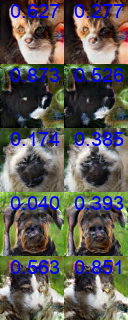

In [16]:
#@title Visualize s-index {form-width: '20%'}

max_images = 50 #@param
sindex =   957#@param
class_index = 0#@param {type: "integer"} 
shift_sign = "1" #@param [0, 1]
wsign_index = int(shift_sign)

shift_size =  1#@param
effect_threshold =  0.2#@param
split_by_class = True #@param {type:"boolean"}
select_images_by_s_distance = False #@param {type:"boolean"}
draw_results_on_image = True #@param {type:"boolean"}

if split_by_class:
  split_ind = 1 if class_index == 0 else 0
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]
  all_s_distances = style_vectors_distances_classes[split_ind]
else:
  all_s = style_change_effect
  all_w = W_values
  all_s_distances = all_style_vectors_distances

font_file = 'arialuni.ttf'
if not os.path.exists(font_file):
  r = requests.get('https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/ipwn/arialuni.ttf')
  open(font_file, 'wb').write(r.content)

if not select_images_by_s_distance:
  yy = visualize_style(generator, 
                       classifier,
                       all_w,
                       all_s,
                       style_min,
                       style_max,
                       sindex,
                       wsign_index,
                       max_images=max_images,
                       shift_size=shift_size,
                       font_file=font_file,
                       label_size=label_size,
                       class_index=class_index,
                       effect_threshold=effect_threshold,
                       draw_results_on_image=draw_results_on_image)
    
else:
  yy = visualize_style_by_distance_in_s(
    generator,
    classifier,
    all_w,
    all_s_distances,
    style_min,
    style_max,
    sindex,
    wsign_index,
    max_images=max_images,
    shift_size=shift_size,
    font_file=font_file,
    label_size=label_size,
    class_index=class_index,
    effect_threshold=effect_threshold,
    draw_results_on_image=draw_results_on_image)


if yy.shape != torch.Size([0]):
  show_image(yy)
else:
  print('no images found')

In [17]:
#@title Show animation {form-width: '20%'}

import matplotlib.animation
from IPython.display import HTML

ani = make_animation(yy, resolution)

HTML(ani.to_jshtml())

<ipython-input-9-2c1c288b68a9>:525: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  base_prob = torch.nn.functional.softmax(result)[0, class_index]
<ipython-input-9-2c1c288b68a9>:418: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  change_prob = torch.nn.functional.softmax(result).cpu().detach().numpy()[0, class_index]


Attribute 0 Skin Pigminatation: 
(Original images are on the first row, the probabilities displayed are for the other class - left column for being old, write column for being young)


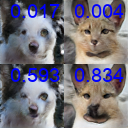

Attribute 1 Eyebrow Thickness: 
(Original images are on the first row, the probabilities displayed are for the other class - left column for being old, write column for being young)


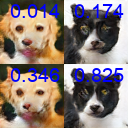

Attribute 2 Add/Remove Glasses: 
(Original images are on the first row, the probabilities displayed are for the other class - left column for being old, write column for being young)


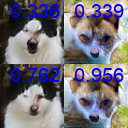

Attribute 3 Dark/White Hair: 
(Original images are on the first row, the probabilities displayed are for the other class - left column for being old, write column for being young)


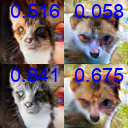

In [23]:
#@title Show the 4 top attributes - as displayed in Fig.4 (b)

draw_probabilities_on_image = True #@param {type: "boolean"}
index_to_naming = {0: "Skin Pigminatation", 1: "Eyebrow Thickness", 2: "Add/Remove Glasses", 3: "Dark/White Hair"}
images_list = [[4, 0], [1, 2], [1, 1], [0, 1]]
max_images = 20
shift_sizes = [(2, 2),(2, 2),(2, 2),(2, 2)]
effect_threshold = 0.2
font_file = 'arialuni.ttf'
if not os.path.exists(font_file):
  gfile.Copy('/google_src/head/depot/google3/googledata/third_party/fonts/ascender/arialuni.ttf', font_file)

for i, (direction, sindex) in enumerate(s_indices_and_signs[:4]):
  images_s = torch.zeros((resolution * 2, resolution * 2, 3))
  for d in [direction, 1 - direction]:
    # Take only images from the offsite class
    class_index = 0 if d == direction else 1
    split_ind = 1 if d == direction else 0
    all_s = style_effect_classes[split_ind]
    all_w = W_classes[split_ind]
    all_s_distances = style_vectors_distances_classes[split_ind]
    # Generate images
    yy = visualize_style_by_distance_in_s(
      generator,
      classifier,
      all_w,
      all_s_distances,
      style_min,
      style_max,
      sindex,
      d,
      max_images=max_images,
      shift_size=shift_sizes[i][class_index],
      font_file=font_file,
      label_size=label_size,
      class_index=class_index,
      effect_threshold=effect_threshold,
      draw_results_on_image=draw_probabilities_on_image)
    
    for n in range(2):
 
      images_s[n * resolution: (n + 1) * resolution, class_index * resolution: (class_index + 1) * resolution, :] = yy[(images_list[i][class_index]) * resolution: (images_list[i][class_index] + 1) * resolution, n * resolution: (n + 1) * resolution, :]
    images_s = images_s.to(torch.int)
  print(f'Attribute {i} {index_to_naming[i]}: \n(Original images are on the first row, the probabilities displayed are for the other class - left column for being old, write column for being young)')
  show_image(images_s)

